## Crypto Prediction with LSTM: Litecoin (LTC)

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-10-23 14:56:43.772188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-10-23T00:00:00.0000000Z', 'time_period_end': '2023-10-24T00:00:00.0000000Z', 'time_open': '2023-10-23T00:03:01.1870000Z', 'time_close': '2023-10-23T18:56:53.1110000Z', 'price_open': 65.3, 'price_high': 67.2, 'price_low': 64.93, 'price_close': 67.07, 'volume_traded': 4881.56678098, 'trades_count': 1511}, {'time_period_start': '2023-10-22T00:00:00.0000000Z', 'time_period_end': '2023-10-23T00:00:00.0000000Z', 'time_open': '2023-10-22T00:02:00.4550000Z', 'time_close': '2023-10-22T23:55:18.8460000Z', 'price_open': 64.75, 'price_high': 66.32, 'price_low': 63.18, 'price_close': 65.21, 'volume_traded': 3294.24806949, 'trades_count': 1245}, {'time_period_start': '2023-10-21T00:00:00.0000000Z', 'time_period_end': '2023-10-22T00:00:00.0000000Z', 'time_open': '2023-10-21T00:11:39.4390000Z', 'time_close': '2023-10-21T23:53:56.7910000Z', 'price_open': 63.45, 'price_high': 65.37, 'price_low': 63.43, 'price_close': 64.77, 'volume_traded': 2486.09233981, 'trades_count': 991

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-10-23T00:00:00.0000000Z,2023-10-24T00:00:00.0000000Z,2023-10-23T00:03:01.1870000Z,2023-10-23T18:56:53.1110000Z,65.30,67.20,64.93,67.07,4881.566781,1511
1,2023-10-22T00:00:00.0000000Z,2023-10-23T00:00:00.0000000Z,2023-10-22T00:02:00.4550000Z,2023-10-22T23:55:18.8460000Z,64.75,66.32,63.18,65.21,3294.248069,1245
2,2023-10-21T00:00:00.0000000Z,2023-10-22T00:00:00.0000000Z,2023-10-21T00:11:39.4390000Z,2023-10-21T23:53:56.7910000Z,63.45,65.37,63.43,64.77,2486.092340,991
3,2023-10-20T00:00:00.0000000Z,2023-10-21T00:00:00.0000000Z,2023-10-20T00:00:37.9390000Z,2023-10-20T23:46:38.6290000Z,61.75,64.19,61.64,63.43,7215.090773,1512
4,2023-10-19T00:00:00.0000000Z,2023-10-20T00:00:00.0000000Z,2023-10-19T00:00:54.6620000Z,2023-10-19T23:55:27.7340000Z,60.25,61.85,59.72,61.79,3339.236544,1022


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


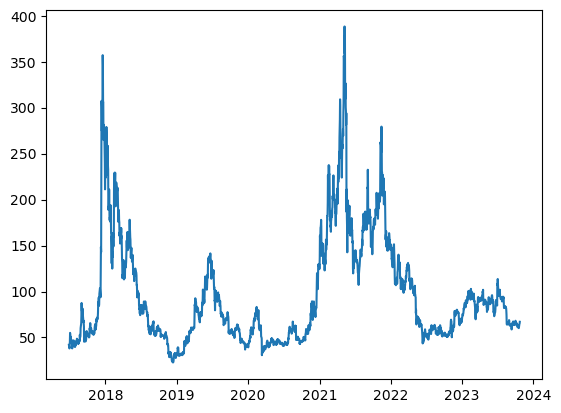

In [5]:
#plot historical ltc price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30 

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#scale data
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape

((2266, 30), (2266,), (2266,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1812, 30), (1812,), (227, 30), (227,), (227, 30), (227,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-10-23 14:57:07.410599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
57/57 [==============================] - 6s 38ms/step - loss: 6.6227 - mean_absolute_error: 2.0188 - val_loss: 0.0667 - val_mean_absolute_error: 0.2284
Epoch 2/100
57/57 [==============================] - 2s 27ms/step - loss: 0.3455 - mean_absolute_error: 0.5078 - val_loss: 0.1281 - val_mean_absolute_error: 0.3071
Epoch 3/100
57/57 [==============================] - 2s 30ms/step - loss: 0.3126 - mean_absolute_error: 0.4849 - val_loss: 0.1035 - val_mean_absolute_error: 0.2751
Epoch 4/100
57/57 [==============================] - 2s 28ms/step - loss: 0.1163 - mean_absolute_error: 0.2640 - val_loss: 0.0752 - val_mean_absolute_error: 0.2520
Epoch 5/100
57/57 [==============================] - 2s 30ms/step - loss: 0.0397 - mean_absolute_error: 0.1525 - val_loss: 0.0129 - val_mean_absolute_error: 0.0892
Epoch 6/100
57/57 [==============================] - 1s 26ms/step - loss: 0.0272 - mean_absolute_error: 0.1226 - val_loss: 0.0256 - val_mean_absolute_error: 0.1432
Epoch 7/100
57/5

Epoch 51/100
57/57 [==============================] - 2s 34ms/step - loss: 0.0051 - mean_absolute_error: 0.0519 - val_loss: 0.0021 - val_mean_absolute_error: 0.0318
Epoch 52/100
57/57 [==============================] - 2s 31ms/step - loss: 0.0043 - mean_absolute_error: 0.0460 - val_loss: 0.0022 - val_mean_absolute_error: 0.0360
Epoch 53/100
57/57 [==============================] - 2s 39ms/step - loss: 0.0046 - mean_absolute_error: 0.0488 - val_loss: 0.0021 - val_mean_absolute_error: 0.0339
Epoch 54/100
57/57 [==============================] - 2s 40ms/step - loss: 0.0059 - mean_absolute_error: 0.0576 - val_loss: 0.0112 - val_mean_absolute_error: 0.0986
Epoch 55/100
57/57 [==============================] - 3s 47ms/step - loss: 0.0047 - mean_absolute_error: 0.0502 - val_loss: 0.0020 - val_mean_absolute_error: 0.0309
Epoch 56/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0045 - mean_absolute_error: 0.0494 - val_loss: 0.0019 - val_mean_absolute_error: 0.0313
Epoch 57/1

57/57 [==============================] - 2s 11ms/step


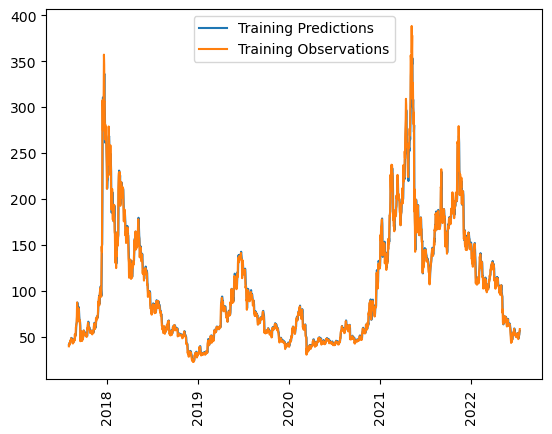

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0018101251916959882
Val MAE: 0.031435515731573105


8/8 [==============================] - 0s 13ms/step


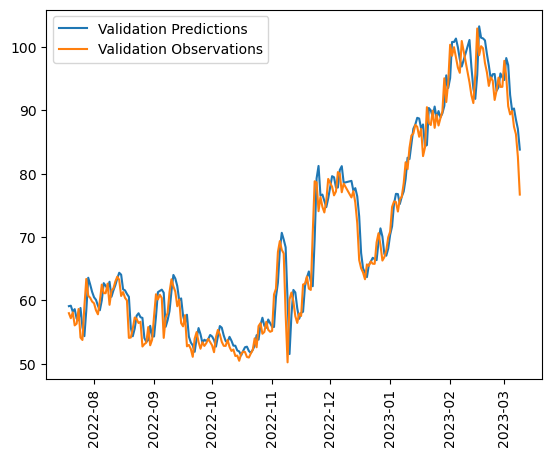

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0015504102921113372
Test MAE: 0.0263949204236269


8/8 [==============================] - 0s 11ms/step


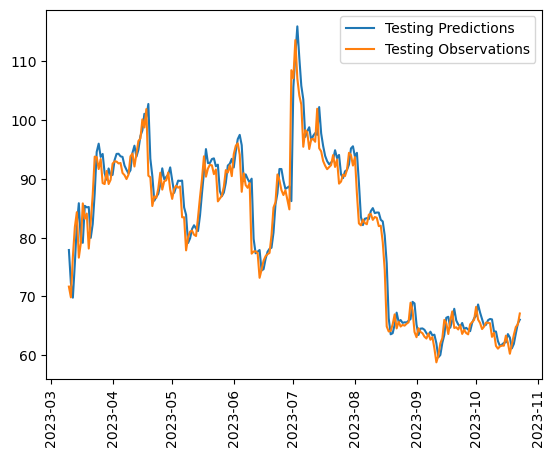

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9419602309633658


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((883,),
 (883, 30),
 (883,),
 (136,),
 (136, 30),
 (136,),
 (114,),
 (114, 30),
 (114,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
57/57 [==============================] - 11s 56ms/step - loss: 6.8308 - mean_absolute_error: 2.0777 - val_loss: 0.0432 - val_mean_absolute_error: 0.1723
Epoch 2/300
57/57 [==============================] - 2s 35ms/step - loss: 0.3242 - mean_absolute_error: 0.4886 - val_loss: 0.0956 - val_mean_absolute_error: 0.2650
Epoch 3/300
57/57 [==============================] - 2s 30ms/step - loss: 0.2179 - mean_absolute_error: 0.3962 - val_loss: 0.0101 - val_mean_absolute_error: 0.0844
Epoch 4/300
57/57 [==============================] - 2s 33ms/step - loss: 0.0450 - mean_absolute_error: 0.1618 - val_loss: 0.0088 - val_mean_absolute_error: 0.0745
Epoch 5/300
57/57 [==============================] - 2s 34ms/step - loss: 0.0230 - mean_absolute_error: 0.1134 - val_loss: 0.0143 - val_mean_absolute_error: 0.1038
Epoch 6/300
57/57 [==============================] - 2s 30ms/step - loss: 0.0191 - mean_absolute_error: 0.1025 - val_loss: 0.0054 - val_mean_absolute_error: 0.0573
Epoch 7/300
57/

Epoch 51/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0045 - mean_absolute_error: 0.0484 - val_loss: 0.0041 - val_mean_absolute_error: 0.0535
Epoch 52/300
57/57 [==============================] - 2s 27ms/step - loss: 0.0062 - mean_absolute_error: 0.0607 - val_loss: 0.0029 - val_mean_absolute_error: 0.0413
Epoch 53/300
57/57 [==============================] - 2s 32ms/step - loss: 0.0043 - mean_absolute_error: 0.0470 - val_loss: 0.0034 - val_mean_absolute_error: 0.0464
Epoch 54/300
57/57 [==============================] - 2s 29ms/step - loss: 0.0045 - mean_absolute_error: 0.0483 - val_loss: 0.0048 - val_mean_absolute_error: 0.0596
Epoch 55/300
57/57 [==============================] - 2s 30ms/step - loss: 0.0050 - mean_absolute_error: 0.0522 - val_loss: 0.0039 - val_mean_absolute_error: 0.0510
Epoch 56/300
57/57 [==============================] - 2s 28ms/step - loss: 0.0047 - mean_absolute_error: 0.0508 - val_loss: 0.0026 - val_mean_absolute_error: 0.0407
Epoch 57/3

Epoch 101/300
57/57 [==============================] - 2s 31ms/step - loss: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288
Epoch 102/300
57/57 [==============================] - 2s 30ms/step - loss: 0.0043 - mean_absolute_error: 0.0475 - val_loss: 0.0024 - val_mean_absolute_error: 0.0372
Epoch 103/300
57/57 [==============================] - 2s 30ms/step - loss: 0.0039 - mean_absolute_error: 0.0445 - val_loss: 0.0017 - val_mean_absolute_error: 0.0296
Epoch 104/300
57/57 [==============================] - 2s 28ms/step - loss: 0.0044 - mean_absolute_error: 0.0495 - val_loss: 0.0024 - val_mean_absolute_error: 0.0367
Epoch 105/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0056 - mean_absolute_error: 0.0574 - val_loss: 0.0040 - val_mean_absolute_error: 0.0543
Epoch 106/300
57/57 [==============================] - 2s 28ms/step - loss: 0.0041 - mean_absolute_error: 0.0462 - val_loss: 0.0021 - val_mean_absolute_error: 0.0354
Epoc

57/57 [==============================] - 1s 25ms/step - loss: 0.0043 - mean_absolute_error: 0.0471 - val_loss: 0.0017 - val_mean_absolute_error: 0.0293
Epoch 151/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0039 - mean_absolute_error: 0.0442 - val_loss: 0.0026 - val_mean_absolute_error: 0.0408
Epoch 152/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0040 - mean_absolute_error: 0.0456 - val_loss: 0.0030 - val_mean_absolute_error: 0.0441
Epoch 153/300
57/57 [==============================] - 1s 24ms/step - loss: 0.0045 - mean_absolute_error: 0.0487 - val_loss: 0.0029 - val_mean_absolute_error: 0.0445
Epoch 154/300
57/57 [==============================] - 1s 24ms/step - loss: 0.0044 - mean_absolute_error: 0.0488 - val_loss: 0.0019 - val_mean_absolute_error: 0.0306
Epoch 155/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0044 - mean_absolute_error: 0.0490 - val_loss: 0.0023 - val_mean_absolute_error: 0.0381
Epoch 156/300
57/5

57/57 [==============================] - 1s 24ms/step - loss: 0.0042 - mean_absolute_error: 0.0473 - val_loss: 0.0017 - val_mean_absolute_error: 0.0299
Epoch 200/300
57/57 [==============================] - 1s 26ms/step - loss: 0.0042 - mean_absolute_error: 0.0478 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288
Epoch 201/300
57/57 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_error: 0.0520 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292
Epoch 202/300
57/57 [==============================] - 2s 27ms/step - loss: 0.0041 - mean_absolute_error: 0.0469 - val_loss: 0.0021 - val_mean_absolute_error: 0.0337
Epoch 203/300
57/57 [==============================] - 2s 27ms/step - loss: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0016 - val_mean_absolute_error: 0.0284
Epoch 204/300
57/57 [==============================] - 1s 26ms/step - loss: 0.0037 - mean_absolute_error: 0.0431 - val_loss: 0.0025 - val_mean_absolute_error: 0.0402
Epoch 205/300
57/5

57/57 [==============================] - 2s 26ms/step - loss: 0.0037 - mean_absolute_error: 0.0425 - val_loss: 0.0016 - val_mean_absolute_error: 0.0289
Epoch 249/300
57/57 [==============================] - 2s 30ms/step - loss: 0.0039 - mean_absolute_error: 0.0453 - val_loss: 0.0016 - val_mean_absolute_error: 0.0285
Epoch 250/300
57/57 [==============================] - 2s 27ms/step - loss: 0.0036 - mean_absolute_error: 0.0424 - val_loss: 0.0017 - val_mean_absolute_error: 0.0293
Epoch 251/300
57/57 [==============================] - 2s 29ms/step - loss: 0.0045 - mean_absolute_error: 0.0493 - val_loss: 0.0045 - val_mean_absolute_error: 0.0585
Epoch 252/300
57/57 [==============================] - 2s 34ms/step - loss: 0.0039 - mean_absolute_error: 0.0456 - val_loss: 0.0022 - val_mean_absolute_error: 0.0340
Epoch 253/300
57/57 [==============================] - 2s 31ms/step - loss: 0.0037 - mean_absolute_error: 0.0428 - val_loss: 0.0016 - val_mean_absolute_error: 0.0286
Epoch 254/300
57/5

57/57 [==============================] - 3s 48ms/step - loss: 0.0037 - mean_absolute_error: 0.0436 - val_loss: 0.0033 - val_mean_absolute_error: 0.0469
Epoch 298/300
57/57 [==============================] - 3s 51ms/step - loss: 0.0040 - mean_absolute_error: 0.0451 - val_loss: 0.0030 - val_mean_absolute_error: 0.0443
Epoch 299/300
57/57 [==============================] - 3s 59ms/step - loss: 0.0044 - mean_absolute_error: 0.0478 - val_loss: 0.0038 - val_mean_absolute_error: 0.0518
Epoch 300/300
57/57 [==============================] - 3s 51ms/step - loss: 0.0039 - mean_absolute_error: 0.0444 - val_loss: 0.0019 - val_mean_absolute_error: 0.0312


57/57 [==============================] - 4s 11ms/step


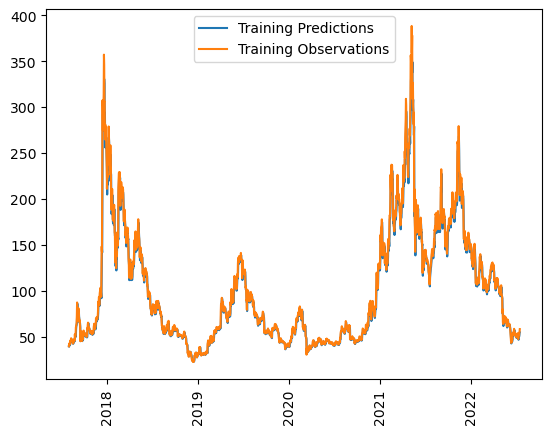

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions2))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002105889841914177
Val MAE: 0.033265359699726105


5/5 [==============================] - 0s 21ms/step


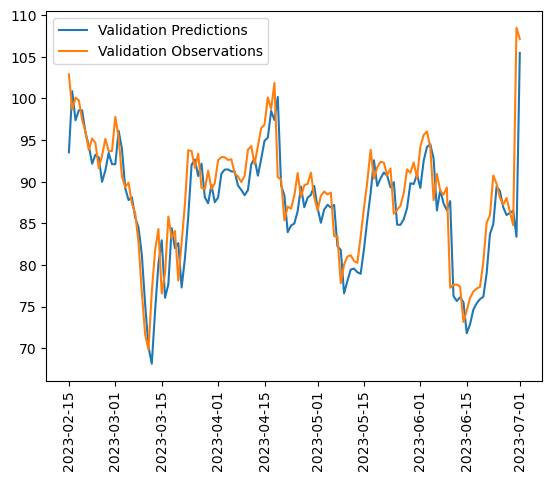

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0010289403144270182
Test MAE: 0.025874702259898186


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 24ms/step
R2 Score:  0.9685751091944419


4/4 [==============================] - 0s 34ms/step


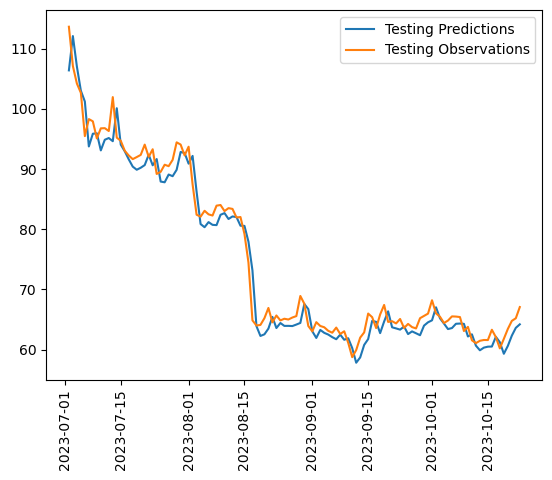

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 17s 174ms/step - loss: 18.3641 - mean_absolute_error: 4.2517 - val_loss: 15.0241 - val_mean_absolute_error: 3.8753
Epoch 2/300
28/28 [==============================] - 1s 51ms/step - loss: 15.3424 - mean_absolute_error: 3.8819 - val_loss: 12.1394 - val_mean_absolute_error: 3.4833
Epoch 3/300
28/28 [==============================] - 1s 53ms/step - loss: 11.8452 - mean_absolute_error: 3.4000 - val_loss: 8.2692 - val_mean_absolute_error: 2.8746
Epoch 4/300
28/28 [==============================] - 1s 47ms/step - loss: 7.5695 - mean_absolute_error: 2.6962 - val_loss: 4.4079 - val_mean_absolute_error: 2.0981
Epoch 5/300
28/28 [==============================] - 1s 54ms/step - loss: 3.8900 - mean_absolute_error: 1.8879 - val_loss: 1.6383 - val_mean_absolute_error: 1.2776
Epoch 6/300
28/28 [==============================] - 1s 42ms/step - loss: 1.5410 - mean_absolute_error: 1.1104 - val_loss: 0.3294 - val_mean_absolute_error: 0.5686
Epoch 7/3

Epoch 51/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0171 - mean_absolute_error: 0.1009 - val_loss: 0.0066 - val_mean_absolute_error: 0.0630
Epoch 52/300
28/28 [==============================] - 1s 29ms/step - loss: 0.0170 - mean_absolute_error: 0.1006 - val_loss: 0.0071 - val_mean_absolute_error: 0.0669
Epoch 53/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0172 - mean_absolute_error: 0.1010 - val_loss: 0.0077 - val_mean_absolute_error: 0.0703
Epoch 54/300
28/28 [==============================] - 1s 29ms/step - loss: 0.0179 - mean_absolute_error: 0.1030 - val_loss: 0.0064 - val_mean_absolute_error: 0.0624
Epoch 55/300
28/28 [==============================] - 1s 44ms/step - loss: 0.0172 - mean_absolute_error: 0.1011 - val_loss: 0.0063 - val_mean_absolute_error: 0.0616
Epoch 56/300
28/28 [==============================] - 1s 46ms/step - loss: 0.0171 - mean_absolute_error: 0.1003 - val_loss: 0.0072 - val_mean_absolute_error: 0.0649
Epoch 57/3

Epoch 101/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0089 - mean_absolute_error: 0.0705 - val_loss: 0.0046 - val_mean_absolute_error: 0.0513
Epoch 102/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0084 - mean_absolute_error: 0.0665 - val_loss: 0.0038 - val_mean_absolute_error: 0.0457
Epoch 103/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0082 - mean_absolute_error: 0.0660 - val_loss: 0.0040 - val_mean_absolute_error: 0.0469
Epoch 104/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0082 - mean_absolute_error: 0.0656 - val_loss: 0.0041 - val_mean_absolute_error: 0.0475
Epoch 105/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0084 - mean_absolute_error: 0.0671 - val_loss: 0.0039 - val_mean_absolute_error: 0.0460
Epoch 106/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0083 - mean_absolute_error: 0.0668 - val_loss: 0.0049 - val_mean_absolute_error: 0.0537
Epoc

28/28 [==============================] - 1s 37ms/step - loss: 0.0058 - mean_absolute_error: 0.0548 - val_loss: 0.0036 - val_mean_absolute_error: 0.0454
Epoch 151/300
28/28 [==============================] - 1s 36ms/step - loss: 0.0059 - mean_absolute_error: 0.0570 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409
Epoch 152/300
28/28 [==============================] - 1s 42ms/step - loss: 0.0058 - mean_absolute_error: 0.0545 - val_loss: 0.0033 - val_mean_absolute_error: 0.0421
Epoch 153/300
28/28 [==============================] - 1s 34ms/step - loss: 0.0056 - mean_absolute_error: 0.0532 - val_loss: 0.0031 - val_mean_absolute_error: 0.0410
Epoch 154/300
28/28 [==============================] - 1s 38ms/step - loss: 0.0056 - mean_absolute_error: 0.0535 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409
Epoch 155/300
28/28 [==============================] - 1s 36ms/step - loss: 0.0058 - mean_absolute_error: 0.0558 - val_loss: 0.0036 - val_mean_absolute_error: 0.0458
Epoch 156/300
28/2

28/28 [==============================] - 1s 36ms/step - loss: 0.0050 - mean_absolute_error: 0.0517 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387
Epoch 200/300
28/28 [==============================] - 1s 43ms/step - loss: 0.0049 - mean_absolute_error: 0.0511 - val_loss: 0.0027 - val_mean_absolute_error: 0.0373
Epoch 201/300
28/28 [==============================] - 1s 41ms/step - loss: 0.0047 - mean_absolute_error: 0.0494 - val_loss: 0.0028 - val_mean_absolute_error: 0.0386
Epoch 202/300
28/28 [==============================] - 1s 46ms/step - loss: 0.0048 - mean_absolute_error: 0.0501 - val_loss: 0.0031 - val_mean_absolute_error: 0.0413
Epoch 203/300
28/28 [==============================] - 1s 48ms/step - loss: 0.0050 - mean_absolute_error: 0.0524 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397
Epoch 204/300
28/28 [==============================] - 1s 41ms/step - loss: 0.0046 - mean_absolute_error: 0.0498 - val_loss: 0.0034 - val_mean_absolute_error: 0.0449
Epoch 205/300
28/2

28/28 [==============================] - 1s 26ms/step - loss: 0.0042 - mean_absolute_error: 0.0469 - val_loss: 0.0027 - val_mean_absolute_error: 0.0381
Epoch 249/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0043 - mean_absolute_error: 0.0476 - val_loss: 0.0024 - val_mean_absolute_error: 0.0342
Epoch 250/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0041 - mean_absolute_error: 0.0453 - val_loss: 0.0024 - val_mean_absolute_error: 0.0341
Epoch 251/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0043 - mean_absolute_error: 0.0466 - val_loss: 0.0029 - val_mean_absolute_error: 0.0401
Epoch 252/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0043 - mean_absolute_error: 0.0478 - val_loss: 0.0035 - val_mean_absolute_error: 0.0462
Epoch 253/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0047 - mean_absolute_error: 0.0505 - val_loss: 0.0025 - val_mean_absolute_error: 0.0360
Epoch 254/300
28/2

28/28 [==============================] - 1s 37ms/step - loss: 0.0037 - mean_absolute_error: 0.0434 - val_loss: 0.0033 - val_mean_absolute_error: 0.0455
Epoch 298/300
28/28 [==============================] - 1s 46ms/step - loss: 0.0038 - mean_absolute_error: 0.0441 - val_loss: 0.0024 - val_mean_absolute_error: 0.0353
Epoch 299/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0039 - mean_absolute_error: 0.0449 - val_loss: 0.0023 - val_mean_absolute_error: 0.0339
Epoch 300/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0038 - mean_absolute_error: 0.0442 - val_loss: 0.0023 - val_mean_absolute_error: 0.0347


28/28 [==============================] - 1s 10ms/step


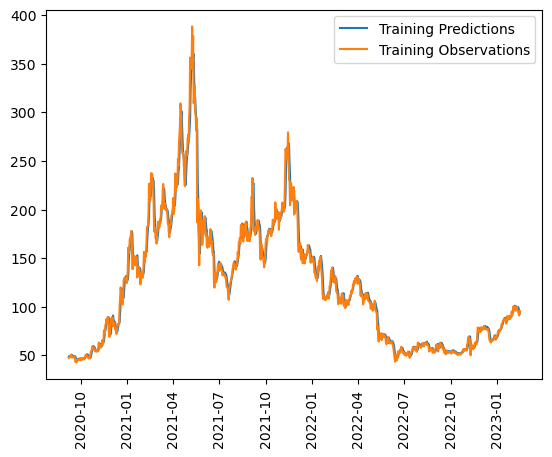

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002349493093788624
Val MAE: 0.034745994955301285


5/5 [==============================] - 0s 44ms/step


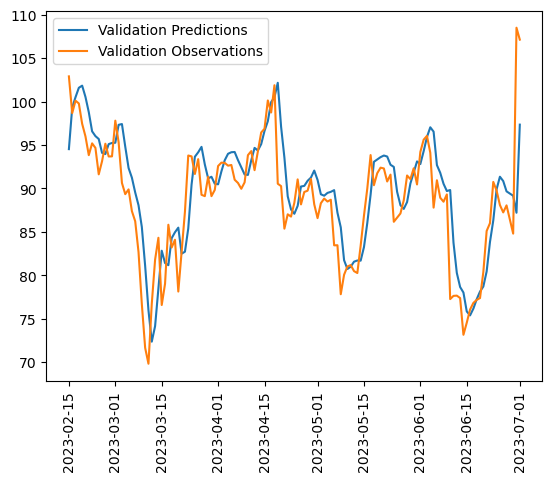

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.001626867218874395
Test MAE: 0.028991229832172394


4/4 [==============================] - 0s 25ms/step


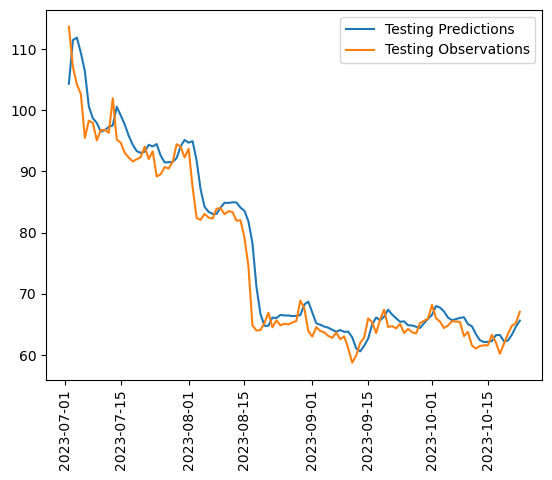

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9503135964185198


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the highest scoring model for future predictions

In [32]:
# Use the first model to predict future values since it has the highest r2 score

# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

# add future dates for predictions
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 68ms/step
[4.1899695, 4.1928906, 4.191619, 4.189693, 4.1885138, 4.1881204, 4.1881247]
2023-10-24
2023-10-25
2023-10-26
2023-10-27
2023-10-28
2023-10-29
2023-10-30


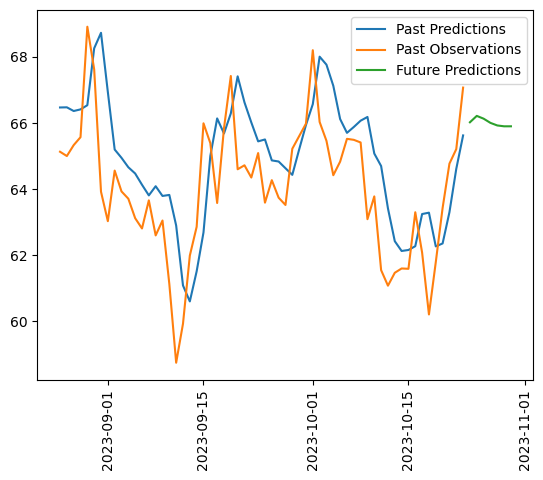

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/ltc_30_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/ltc_30_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_30_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-07-26,90.71,90.117805,87.791786,91.467308
2023-07-27,90.47,91.273636,89.080894,91.493561
2023-07-28,91.52,91.531967,88.805771,91.546982
2023-07-29,94.43,92.435722,89.868774,92.179588
2023-07-30,94.06,95.175507,92.826050,94.090767
...,...,...,...,...
2023-10-19,61.79,61.126389,59.311249,62.267384
2023-10-20,63.43,61.892391,60.612885,62.356464
2023-10-21,64.77,63.670528,62.316540,63.300873


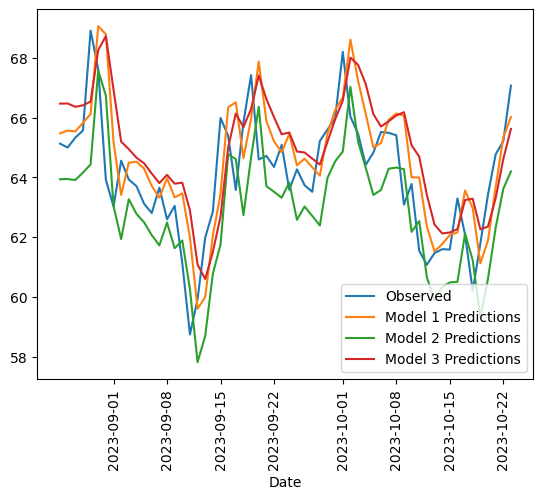

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/ltc_predict_30.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime_30.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9419602309633658
Model 2 R2 Score:  0.9685751091944419
Model 3 R2 Score:  0.9503135964185198
